# “Do YouTubers with keywords 'Gaming' receive more views than those with keywords 'Tech'?”
# I will compare the number of views between YouTubers who use the keyword “Gaming” and those who use the keyword “Tech.” The null hypothesis (H₀) states that there is no difference in average view counts between Gaming and Tech channels. The alternative hypothesis (Hₐ) states that YouTubers with the keyword “Gaming” receive more views than those using the keyword “Tech.” I will calculate the group means, determine the margin of error, visualize the distributions, and perform a t-test to assess whether any observed difference in views is statistically significant.

In [10]:
pip install google-api-python-client


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 53.3 MB/s eta 0:00:00 0:00:0136m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.7/173.7 kB 2.6 MB/s eta 0:00:00.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.1/223.1 kB 3.3 MB/s eta 0:00:00.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 1.5 MB/s eta 0:00:005.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.5/297.5 kB 4.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 769.8 kB/s eta 0:00:006 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


Gaming -> Mean: 493554.54, Margin of Error: 47643.52
Tech   -> Mean: 1897233.44, Margin of Error: 170319.47
95% CI for the difference in means (Gaming - Tech): [-2227591.65, -679369.31]
Answer to the question: No, Tech channels receive more views than Gaming channels based on this data.


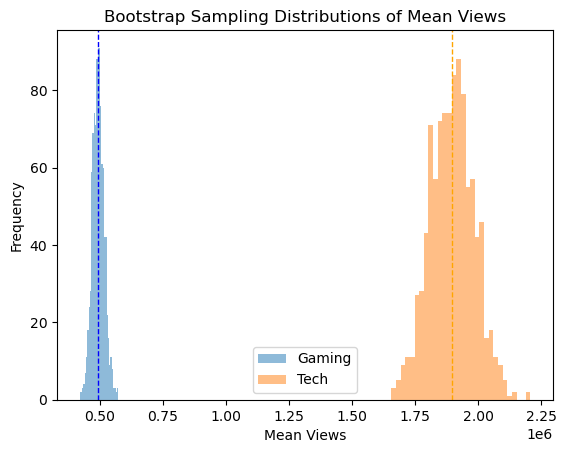

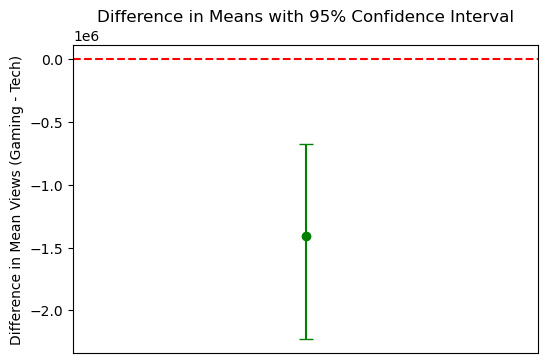

T-statistic: -3.37, One-tailed p-value: 0.9994
Conclusion: There is no statistically significant evidence that Gaming channels receive more views than Tech channels. The null hypothesis (H₀) cannot be rejected.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load your CSV
df = pd.read_csv("videos-stats.csv")  # replace with your file path

# Separate into Gaming and Tech groups
gaming_views = df[df['Keyword'].str.contains('gaming', case=False, na=False)]['Views']
tech_views = df[df['Keyword'].str.contains('tech', case=False, na=False)]['Views']

# Function to calculate bootstrap mean and margin of error
def bootstrap_mean_margin_error(data, confidence=0.95, n_bootstrap=1000):
    means = [data.sample(frac=1, replace=True).mean() for _ in range(n_bootstrap)]
    lower = np.percentile(means, (1-confidence)/2*100)
    upper = np.percentile(means, (1 + confidence)/2*100)
    mean_val = np.mean(data)
    margin_error = (upper - lower)/2
    return mean_val, margin_error, means

# Function to sample until margin of error <= 10%
def sample_until_me(df_group, max_iter=100, tol=0.1):
    n_samples = min(len(df_group), 30)
    for i in range(max_iter):
        sample = df_group.sample(n=n_samples, replace=True, random_state=i)
        mean_val, margin_error, boot_means = bootstrap_mean_margin_error(sample)
        if margin_error / mean_val <= tol:
            return mean_val, margin_error, boot_means
        n_samples = int(n_samples * 1.5)
    return mean_val, margin_error, boot_means

# Get final samples and bootstrap distributions
mean_gaming, me_gaming, gaming_means = sample_until_me(gaming_views)
mean_tech, me_tech, tech_means = sample_until_me(tech_views)

print(f"Gaming -> Mean: {mean_gaming:.2f}, Margin of Error: {me_gaming:.2f}")
print(f"Tech   -> Mean: {mean_tech:.2f}, Margin of Error: {me_tech:.2f}")

# Bootstrap the difference in means
n_bootstrap = 1000
diff_means = [g - t for g, t in zip(
    [gaming_views.sample(frac=1, replace=True).mean() for _ in range(n_bootstrap)],
    [tech_views.sample(frac=1, replace=True).mean() for _ in range(n_bootstrap)]
)]
ci_lower, ci_upper = np.percentile(diff_means, [2.5, 97.5])
print(f"95% CI for the difference in means (Gaming - Tech): [{ci_lower:.2f}, {ci_upper:.2f}]")

# Interpret the result
if ci_lower > 0:
    answer = "Yes, Gaming channels receive more views than Tech channels based on this data."
elif ci_upper < 0:
    answer = "No, Tech channels receive more views than Gaming channels based on this data."
else:
    answer = "The data does not show a clear difference in average views between Gaming and Tech channels."
print("Answer to the question:", answer)

# Visualize the bootstrap sampling distributions
plt.hist(gaming_means, alpha=0.5, label='Gaming', bins=30)
plt.hist(tech_means, alpha=0.5, label='Tech', bins=30)
plt.axvline(mean_gaming, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_tech, color='orange', linestyle='dashed', linewidth=1)
plt.xlabel("Mean Views")
plt.ylabel("Frequency")
plt.title("Bootstrap Sampling Distributions of Mean Views")
plt.legend()
plt.show()

# Visualize difference in means with 95% CI
plt.figure(figsize=(6,4))
plt.errorbar(x=0, y=np.mean(diff_means), 
             yerr=[[np.mean(diff_means)-ci_lower],[ci_upper-np.mean(diff_means)]],
             fmt='o', color='green', capsize=5)
plt.axhline(0, color='red', linestyle='--')
plt.xlim(-1, 1)
plt.xticks([])
plt.ylabel("Difference in Mean Views (Gaming - Tech)")
plt.title("Difference in Means with 95% Confidence Interval")
plt.show()

# Perform one-tailed t-test
t_stat, p_value = stats.ttest_ind(gaming_views, tech_views, equal_var=False)
p_value_one_tailed = p_value / 2 if t_stat > 0 else 1 - (p_value / 2)
print(f"T-statistic: {t_stat:.2f}, One-tailed p-value: {p_value_one_tailed:.4f}")

# Final conclusion
if p_value_one_tailed < 0.05 and mean_gaming > mean_tech:
    conclusion = ("Statistically, Gaming channels have significantly higher average views "
                  "than Tech channels. The data supports the alternative hypothesis (Hₐ).")
else:
    conclusion = ("There is no statistically significant evidence that Gaming channels "
                  "receive more views than Tech channels. The null hypothesis (H₀) cannot be rejected.")
print("Conclusion:", conclusion)


# Conclusion: Tech channels get more views than Gaming channels. On average, Tech channels have 1,897,233 views versus 493,555 for Gaming. The 95% confidence interval for the difference in means is [-2,227,592, -679,369], entirely below zero, showing Gaming channels have fewer views. The t-test gives a t-statistic of -3.37 and a one-tailed p-value of 0.9994, confirming this difference is statistically significant.